In [2]:
"""
Created on Thu Sep 22 13:06:00 2022

# Explorative Data Analysis Workship 1


The instructions in this file assume that you are using Spyder by Anaconda. 
They might be different if you are using Juypler. For example: Jupyler prints
all columns when you use the command df.head(). Syder just prints some columns, 
and it is desirable to use the Variable Explorer instead. 


# Objective:
    1.- Develop a regression algorithm
    2.- Plot residuals and verify distribution.
    3.- Obtain the R-Squared values
    4.- Analyse Influencial Waypoints
    5.- Cook's Distance
    6.- Predict Values
    
@author: Alejandro Murrieta-Mendoza
"""
# 0: Import all your required libreries 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import pandas as pd
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

import math

Data courtesy of *Mohith Sai Ram Reddy* on Kaggle:

https://www.kaggle.com/datasets/mohithsairamreddy/salary-data/

In [3]:
df = pd.read_csv('salary_data.csv')

df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [4]:
df.shape

(6704, 6)

In [5]:
df.dtypes

Age                    float64
Gender                  object
Education Level         object
Job Title               object
Years of Experience    float64
Salary                 float64
dtype: object

I love this dataset so much more already... There is some actually workable data here. Let's check for null values

In [6]:
df.isna().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

Just a couple, let's filter them out.

In [7]:
df = df.dropna()

In [8]:
df.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64

Let's also get some shorter column names

In [9]:
df.columns = ['age', 'gender', 'education', 'title', 'exp', 'salary']

df.head()

,age,gender,education,title,exp,salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


The data is clean enough with these few steps. Let's explore the data a bit.

In [10]:
df.describe()

,age,exp,salary
count,6698.000000,6698.000000,6698.000000
mean,33.623022,8.095178,115329.253061
std,7.615784,6.060291,52789.792507
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [11]:
from typing import Literal


def plot_salary(df: pd.DataFrame, category: Literal["age", "exp", "education", "gender", "title"], title: str, xlabel: str) -> None:
    x = df[category]
    plt.figure(figsize=(10, 5))
    plt.scatter(x, df['salary'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

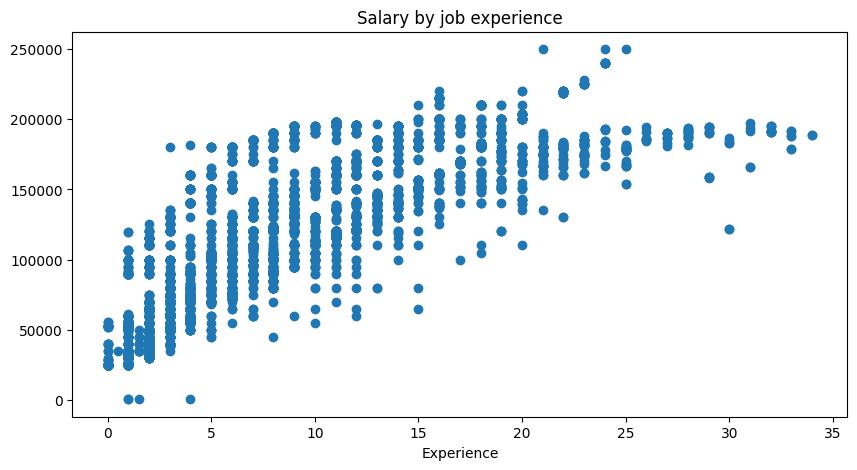

In [12]:
plot_salary(df=df, category="exp", title="Salary by job experience", xlabel="Experience")

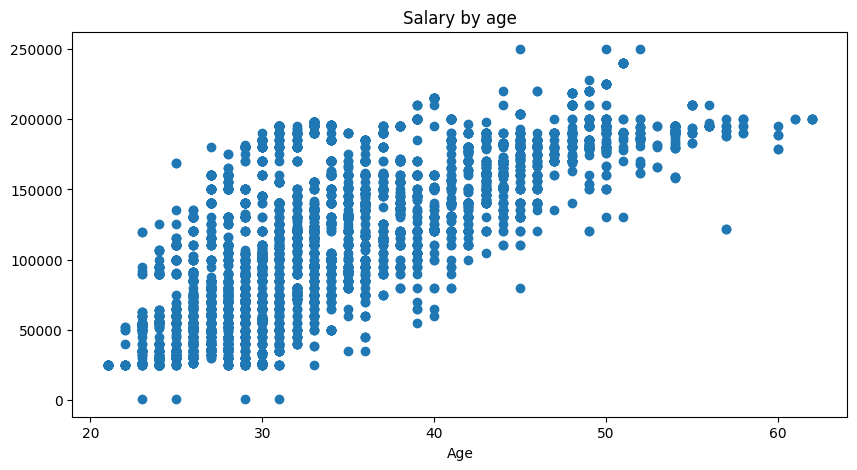

In [13]:
plot_salary(df=df, category="age", title="Salary by age", xlabel="Age")

Let's explore a linear regression model for salary by age. 

In [14]:
model = sm.OLS(df['salary'], sm.add_constant(df['age'])).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     7553.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        01:03:09   Log-Likelihood:                -79809.
No. Observations:                6698   AIC:                         1.596e+05
Df Residuals:                    6696   BIC:                         1.596e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.435e+04   2001.901    -27.151      0.000   -5.83e+04   -5.04e+04
age         5046.6464     58.069     86.908      0.000    4932.813    5160.480
==============================================================================
Omnibus:                      337.395   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              389.872
Skew:                           0.590   Prob(JB):                     2.19e-85
Kurtosis:                       2.927   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Some interesting values:

In [15]:
print(f"b0: {model.params.const:.2f}, b1: {model.params.age:.2f}\nR^2: {model.rsquared:.3f}")

b0: -54354.25, b1: 5046.65
R^2: 0.530


The corresponding linear regression equation is:\
$f(x) = -54354.25 + x \cdot 5046.65$

Now, let's plot the linear regression:

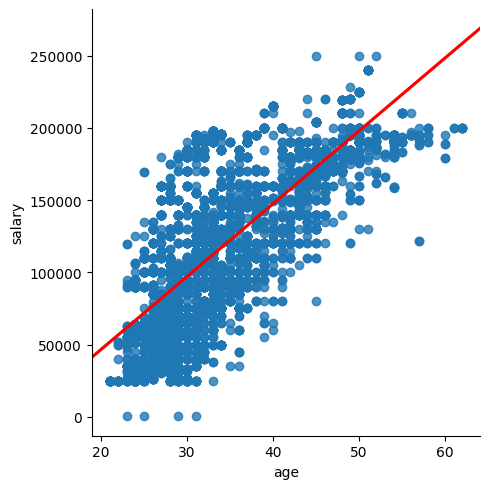

In [16]:
sns.lmplot(data=df, x='age', y='salary', line_kws={'color': 'red'}, ci=None, truncate=None)

Let's look at the residuals of the datapoints

In [17]:
resid = model.resid.apply(lambda x: math.sqrt(x**2))

largest_points = resid.nlargest(10)

largest_points

2387    111854.595137
2467    111854.595137
4633    101591.789640
945      98094.795821
2376     97347.088552
2456     97347.088552
598      92954.856725
511      92908.210360
534      92908.210360
547      92908.210360
dtype: float64

<Axes: xlabel='age', ylabel='salary'>

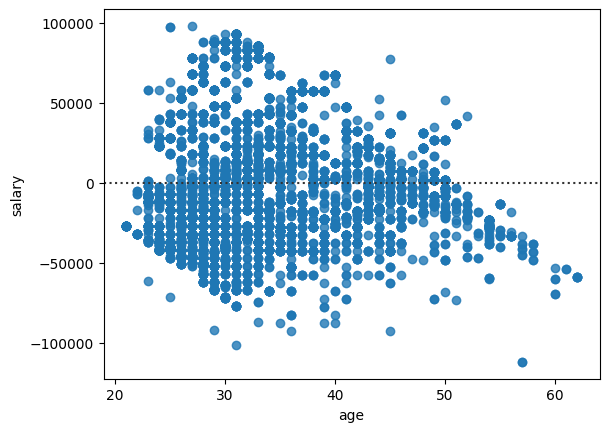

In [18]:
sns.residplot(data=df, x='age', y='salary')

Let's look at which points have the most influence on the linear regression

In [19]:
np.mean(df['age'])

33.62302179755151

In [20]:
influence = model.get_influence()
influence_summary = influence.summary_frame()

In [21]:
influence_summary.head()

,dfb_const,dfb_age,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.002481,0.001233,0.000018,-0.473595,0.000156,-0.005917,-0.473568,-0.005917
1,-0.006976,0.005474,0.000042,-0.606629,0.000231,-0.009215,-0.606601,-0.009215
2,0.009497,-0.011477,0.000095,-0.628622,0.000483,-0.013812,-0.628594,-0.013811
3,0.001899,-0.007097,0.000284,-1.860434,0.000164,-0.023816,-1.860776,-0.023820
4,0.005817,-0.006582,0.000025,-0.223136,0.001019,-0.007126,-0.223121,-0.007125


The column with the title *hat_diag* contains the influence of a point. Let's plot it.

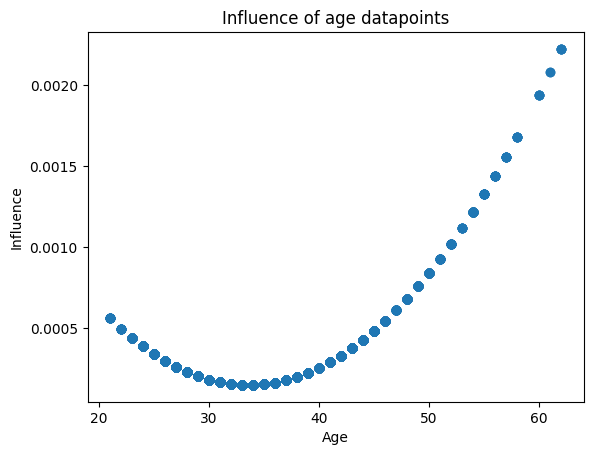

In [22]:
plt.scatter(x=df['age'], y=influence_summary['hat_diag'])
plt.xlabel("Age")
plt.ylabel("Influence")
plt.title("Influence of age datapoints")
plt.show()

Now, let's look at the Cook's distance of each point.

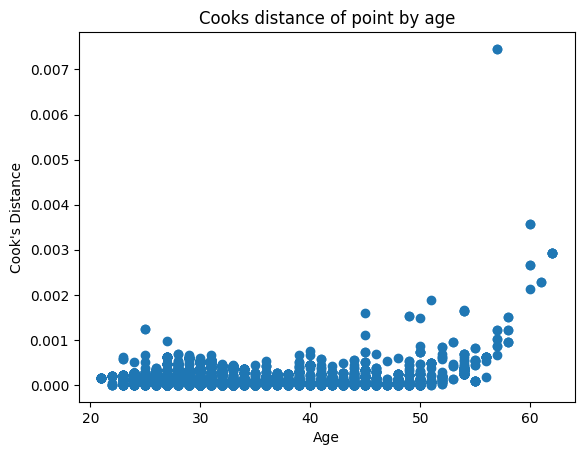

In [23]:
plt.scatter(x=df['age'], y=influence_summary['cooks_d'])
plt.xlabel("Age")
plt.ylabel("Cook's Distance")
plt.title("Cooks distance of point by age")
plt.show()

We can see from this graph, that most of the outliers are in the upper age range. This is because the influence of datapoints in the upper age range is bigger than the lower ones, and there are more points with high residual values in the upper age range.

There are multiple ways to deal with outliers, in this case I will remove them from the dataset. Firstly, let's look at what value for the Cook's distance is considered too high.

In [24]:
cooks = influence.cooks_distance[0]
cooks_mean = np.mean(cooks)

cooks_mean

0.00012687587780223073

For this case, let's say that any value for the cooks distance higher than $5 \cdot D_i$ is too high. 

In [25]:
outliers = np.where(cooks > cooks_mean * 5)

print(outliers[0])
print(len(outliers[0]))

[  30   50   52   66   83   99  112  116  127  135  258  595  943 1199
 1209 1221 1223 1234 1256 1258 1264 1267 1275 1302 1303 1306 1368 1403
 1414 1451 1888 2373 2375 2379 2381 2384 2393 2395 2398 2418 2432 2453
 2455 2459 2461 2464 2473 2475 2478 2498 2512 2538 2551 2580 2604 2797
 2826 2916 2945 3035 3064 4629 4997 6256 6263 6297 6312 6351]
68


In this case, we're removing 68 values from the dataset. This is reasonable, as the total number of datapoints in the set is 6698. First, let's have a closer look at what these outliers look like.

In [26]:
outliers_df = df.iloc[outliers[0], :]
outliers_df

,age,gender,education,title,exp,salary
30,50.0,Male,Bachelor's,CEO,25.0,250000.0
50,51.0,Female,Bachelor's,Customer Service Manager,22.0,130000.0
52,40.0,Female,Bachelor's,Event Coordinator,12.0,60000.0
66,46.0,Male,Bachelor's,IT Manager,19.0,120000.0
83,52.0,Male,PhD,Chief Technology Officer,24.0,250000.0
...,...,...,...,...,...,...
6261,45.0,Female,Master's Degree,Sales Manager,8.0,80000.0
6268,50.0,Male,PhD,Senior Product Marketing Manager,15.0,150000.0
6302,50.0,Male,PhD,Senior Product Marketing Manager,15.0,150000.0
6317,50.0,Female,Bachelor's Degree,Sales Manager,15.0,150000.0


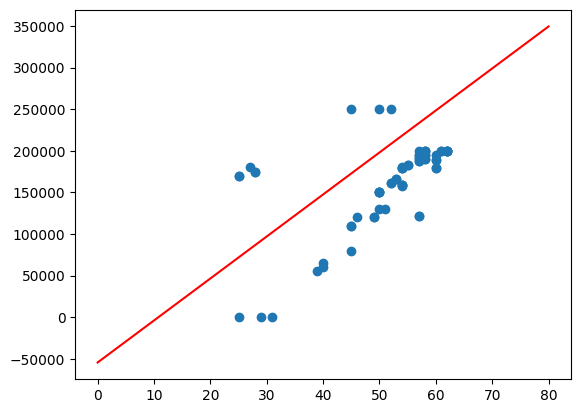

In [27]:
plt.scatter(x=outliers_df['age'], y=outliers_df['salary'])

reg_x = [0, 80]
reg_y = [model.params.const, model.params.const + 80 * model.params.age]

plt.plot(reg_x, reg_y, color='red')

Now, let's drop the outliers and assign the result to a new dataframe

In [28]:
df_filtered = df.drop(df.iloc[outliers[0], :].index, axis=0)

print(f"The old df has {df.shape[0]} rows, the filtered df has {df_filtered.shape[0]} rows")

The old df has 6698 rows, the filtered df has 6630 rows


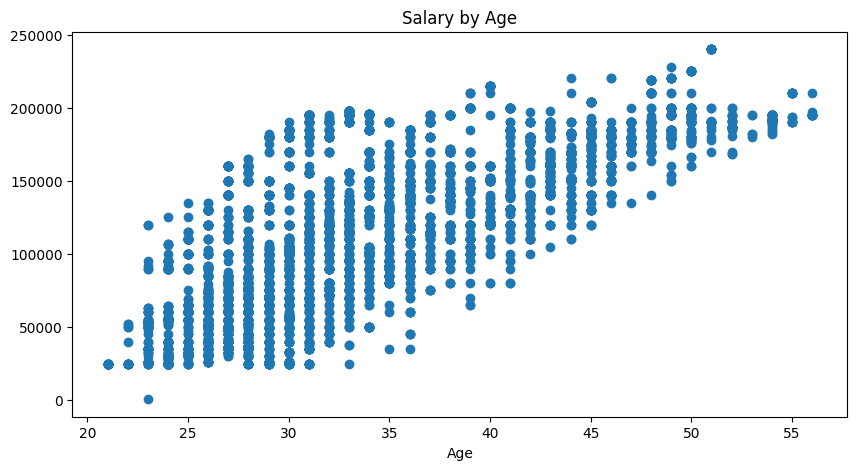

In [29]:
plot_salary(df=df_filtered, category='age', title="Salary by Age", xlabel="Age")

Now, let's fit a new model with our filtered data.

In [30]:
model_filtered = sm.OLS(df_filtered['salary'], sm.add_constant(df_filtered['age'])).fit()

model_filtered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     7691.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        01:03:17   Log-Likelihood:                -78922.
No. Observations:                6630   AIC:                         1.578e+05
Df Residuals:                    6628   BIC:                         1.579e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -5.99e+04   2040.439    -29.354      0.000   -6.39e+04   -5.59e+04
age         5224.9994     59.578     87.701      0.000    5108.208    5341.791
==============================================================================
Omnibus:                      382.714   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              452.010
Skew:                           0.639   Prob(JB):                     7.03e-99
Kurtosis:                       2.943   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's compare the regression equations and values for $R^2$

In [31]:
print(f"b0: {model_filtered.params.const:.2f}, b1: {model_filtered.params.age:.2f}\nR^2: {model_filtered.rsquared:.3f}")

b0: -59895.27, b1: 5225.00
R^2: 0.537


The equation for the unfiltered model is:
$f(x) = -54354.25 + x \cdot 5046.65$

The equation for the filtered model is:
$f(x) = -59895.27 + x \cdot 5225.00$


In [32]:
print(f"The value of R^2 for the unfiltered dataset was {model.rsquared:.4f}.\nWith the filtering of data, this changed to {model_filtered.rsquared:.4f}\nThis is an increase of {model_filtered.rsquared - model.rsquared:.4f}")

The value of R^2 for the unfiltered dataset was 0.5301.
With the filtering of data, this changed to 0.5371
This is an increase of 0.0071


Now, this isn't much of an increase. This can be explained by the rather high variance of most of the datapoints. Removing some outliers still doesn't change this fact. So The R^2 was increased by removing some outliers, but just not a whole lot.

In [33]:
regr = linear_model.LinearRegression()
regr.fit(df[['age', 'exp']], df['salary'])

LinearRegression()

In [38]:
coef = regr.coef_
score = regr.score(df[['age', 'exp']], df['salary'])
intercept = regr.intercept_

print(f"b0: {intercept}, b1: {coef[0]}, b2: {coef[1]} R^2: {score}")

b0: 100519.38459857466, b1: -1753.6722922738707, b2: 9113.281168629945 R^2: 0.6621532808507764


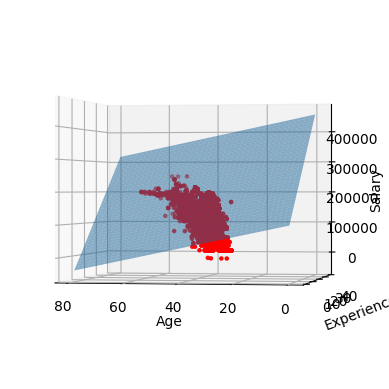

In [88]:
from matplotlib.animation import FuncAnimation


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age'], df['exp'], df['salary'], color='red', marker='.')
ax.set_xlabel("Age")
ax.set_ylabel("Experience")
ax.set_zlabel("Salary")

xs = np.tile(np.arange(80), (40, 1))
ys = np.tile(np.arange(40), (80, 1)).T
zs = xs * coef[0] + ys * coef[1] + intercept
ax.plot_surface(xs, ys, zs, alpha=0.5)
ax.invert_xaxis()

ax.view_init(roll=0, azim=-80, elev=0)


plt.show()

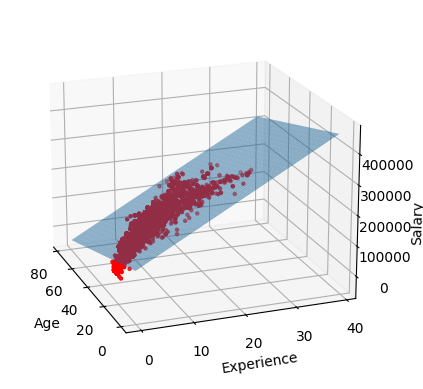

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['age'], df['exp'], df['salary'], color='red', marker='.')
ax.set_xlabel("Age")
ax.set_ylabel("Experience")
ax.set_zlabel("Salary")

xs = np.tile(np.arange(80), (40, 1))
ys = np.tile(np.arange(40), (80, 1)).T
zs = xs * coef[0] + ys * coef[1] + intercept
ax.plot_surface(xs, ys, zs, alpha=0.5)
ax.invert_xaxis()

ax.view_init(roll=0, azim=0, elev=10)


def update(t):
    ax.cla()
    ax.set_xlabel("Age")
    ax.set_ylabel("Experience")
    ax.set_zlabel("Salary")
    ax.view_init(azim=-80 + t * 0.6, elev=-20 + t * 0.4)
    ax.scatter(df['age'], df['exp'], df['salary'], color='red', marker='.')
    ax.plot_surface(xs, ys, zs, alpha=0.5)
    ax.invert_xaxis()

ani = FuncAnimation(fig=fig, func=update, frames=100, interval=100)

ani.save('./ani2.gif')

plt.show()